In [1]:
import nltk
import pandas as pd
import os
import sys
import numpy as np
import glob
from nltk.stem import WordNetLemmatizer 
from nltk.tokenize import sent_tokenize, word_tokenize
nltk.download('stopwords')
from nltk.corpus import stopwords
# ===================================
from torch import FloatTensor as FT
from torch import LongTensor as LT
import re
from collections import Counter
from torchtext.vocab import FastText
EMBEDDING = FastText('simple')
from joblib import Parallel,delayed
from torchtext.vocab import Vocab

MAX_SENT_LEN = 15
MAX_NUM_SENT = 10
PADDING_WORD = 'unk'
# ------------------------------
import torch
from torch.nn import functional as F
import HAN


[nltk_data] Downloading package stopwords to /home/ddatta/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [71]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
EMBEDDING.get_vecs_by_tokens('unk')

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

In [4]:
corpus = {}
max_len = 0
id = 0 
FILE_LOC = './IMDB/train/'
files_list = [glob.glob(os.path.join(FILE_LOC,'pos', '**.txt')),  glob.glob(os.path.join(FILE_LOC,'neg', '**.txt'))]
labels = [1,0] 
stopWords = list(stopwords.words('english'))

# --------------------------------
# Main input processor
# Returns :
# doc : each element is a list of lists
# sentence_lengths : each element is lists
# --------------------------------
def aux(file):
    global stopWords
    global MAX_SENT_LEN
    global PADDING_WORD
    with open(file,'r') as fh:
        doc = fh.readlines()
    sent_lengths = []
    doc = str(doc[0])
    doc = re.sub('<[^<]+?>', '', doc)
    lemmatizer = WordNetLemmatizer()
    word_tokenizer_re = nltk.RegexpTokenizer(r"\w+")
    sentences = sent_tokenize(doc)
    doc = []
    
    for j in range(len(sentences)):
        sentence = word_tokenizer_re.tokenize(sentences[j])
        sentence = [lemmatizer.lemmatize(w.lower()) for idx,w in enumerate(sentence) 
                                  if w.lower() not in stopWords and w.isalnum() and len(w)>1 ]
        if len(sentence)>1:
            if len(sentence) > MAX_SENT_LEN:
                sentence = sentence[:MAX_SENT_LEN]
                sent_lengths.append(MAX_SENT_LEN)
            else:
                sent_lengths.append(len(sentence))
                pad_len = MAX_SENT_LEN - len(sentence)
                pad = [ PADDING_WORD for _ in range(pad_len)]
                sentence = pad + sentence 
            doc.append(sentence)
            
    return (doc , sent_lengths)

id = 0
counter_words = []
for label, files in zip(labels, files_list):
    results = Parallel(16)( delayed(aux)(file) for file in files)
    for element in results :
        corpus[id] = {}
        corpus[id]['text'] = element[0]
        corpus[id]['label'] =  label
        corpus[id]['lengths'] = element[1]
        id +=1 
           

# --------------
## We donot convert to numeric ids 
## Since we use FastText Embedding 
# --------------

In [5]:

import torch

In [6]:
embedding_size = EMBEDDING['unk'].shape[-1]
hidden_dim = 64

In [7]:
# Masks should be of shape 
# [ Max # of sentences, ]



# emb_data = []
# word_masks = []
# sentence_masks = []
# id_list = list(range(8))
# for id in id_list:
#     doc = corpus[id]['text'][:MAX_NUM_SENT]
#     lengths = corpus[id]['lengths'][:MAX_NUM_SENT]
#     num_sent = len(doc)
#     if num_sent < MAX_NUM_SENT:
#         mask0 = np.zeros([MAX_NUM_SENT-num_sent, MAX_SENT_LEN])
#         mask1 = np.array(
#             [np.array(np.zeros(MAX_SENT_LEN - _ ).tolist() + np.ones(_).tolist()) 
#              for _ in lengths]
#         )
#         w_mask = np.vstack([mask0,mask1])
#         s_mask = np.array(np.zeros(MAX_NUM_SENT - num_sent).tolist() + np.ones(num_sent).tolist())
        
#         # -----------------------------
#         # pad the embeddings with 0s
#         # -----------------------------
#         pad = torch.zeros([MAX_NUM_SENT-num_sent, MAX_SENT_LEN, embedding_size])
#         doc = [ EMBEDDING.get_vecs_by_tokens(_) for _ in doc ]
#         doc = torch.stack(doc)
#         doc_emb = torch.cat([pad,doc],dim=0)  
#     else:
#         w_mask = np.array([np.array(np.zeros(MAX_SENT_LEN - _ ).tolist() + np.ones(_).tolist()) for _ in lengths])
#         doc_emb = torch.stack([ EMBEDDING.get_vecs_by_tokens(_) for _ in doc ])
#         s_mask = np.ones(MAX_NUM_SENT)
   
#     word_masks.append(w_mask) 
#     sentence_masks.append(s_mask)
#     emb_data.append(doc_emb)

# emb_data = FT(torch.stack(emb_data))
# word_masks = LT(masks)
# sentence_masks = LT(sentence_masks)


In [61]:
from sklearn.model_selection import train_test_split

class HAN_data_generator:
    def __init__(self, corpus, batch_size=256):
        self.corpus = corpus
        labels = []
        id_list = []
        for _id,_item in corpus.items():
            labels.append(_item['label'])
            id_list.append(_id)
        
        label_data = np.vstack([np.array(id_list),np.array(labels)]).transpose()
        print(label_data.shape)
        labels_df = pd.DataFrame(
            data = label_data,
            columns = ['id','label']
        )
        # Assume balance class distribution
        self.train_id_labels, self.test_id_labels = train_test_split(labels_df, test_size=0.2)
        self.batch_size = batch_size
        
    
    def get_test_data(self):
        return
    
    def get_train_data(self):
        # Ransdomly sample 
        samples =  self.train_id_labels.sample(n=self.batch_size)
        
        id_list =  samples['id'].values
        batch_labels =  samples['label'].values
        
        emb_data = []
        word_masks = []
        sentence_masks = []
       
        for _id in id_list:
            doc = corpus[_id]['text'][:MAX_NUM_SENT]
            lengths = corpus[_id]['lengths'][:MAX_NUM_SENT]
            num_sent = len(doc)
            if num_sent < MAX_NUM_SENT:
                mask0 = np.zeros([MAX_NUM_SENT-num_sent, MAX_SENT_LEN])
                mask1 = np.array(
                    [np.array(np.zeros(MAX_SENT_LEN - _ ).tolist() + np.ones(_).tolist()) 
                     for _ in lengths]
                )
                w_mask = np.vstack([mask0,mask1])
                s_mask = np.array(np.zeros(MAX_NUM_SENT - num_sent).tolist() + np.ones(num_sent).tolist())

                # -----------------------------
                # pad the embeddings with 0s
                # -----------------------------
                pad = torch.zeros([MAX_NUM_SENT-num_sent, MAX_SENT_LEN, embedding_size])
                doc = [EMBEDDING.get_vecs_by_tokens(_) for _ in doc ]
                doc = torch.stack(doc)
                doc_emb = torch.cat([pad,doc],dim=0)  
            else:
                w_mask = np.array([np.array(np.zeros(MAX_SENT_LEN - _ ).tolist() + np.ones(_).tolist()) for _ in lengths])
                doc_emb = torch.stack([ EMBEDDING.get_vecs_by_tokens(_) for _ in doc ])
                s_mask = np.ones(MAX_NUM_SENT)

            word_masks.append(w_mask) 
            sentence_masks.append(s_mask)
            emb_data.append(doc_emb)

        emb_data = FT(torch.stack(emb_data))
        word_masks = LT(word_masks)
        sentence_masks = LT(sentence_masks)
        return emb_data, word_masks, sentence_masks, batch_labels
    

In [62]:

# word_enc = HAN.word_encoder(
#     inp_emb_dim = embedding_size, 
#     hidden_dim = hidden_dim
# )

# emb_data.shape

# w_mask = word_masks
# batch_sentences = []
# for i in range(emb_data.shape[0]):
#     doc_emb_data = emb_data[i]
#     bs = doc_emb_data.shape[0]
#     word_enc.get_init_state(bs)
#     sent_op = word_enc(
#         FT(doc_emb_data), 
#         _mask,
#         word_enc.get_init_state(bs)
#     )
#     batch_sentences.append(sent_op)
# batch_sentences = torch.stack(batch_sentences)

# batch_sentences[0].shape

# sentence_enc = HAN.sentence_encoder(2*hidden_dim,hidden_dim)

In [63]:


# batch_sentences.shape
# batch_size = batch_sentences.shape[0]
# res = sentence_enc(batch_sentences, sentence_masks, sentence_enc.get_init_state(batch_size) )
# res.shape
# sentence_masks

In [64]:
class HAN_model_container:
    def __init__(
        self,
        embedding_size = 300,
        hidden_dim_1 = 64,
        hidden_dim_2 = 32,
        num_classes = 2
    ):
        # -------------------
        # Final layer 
        # -------------------
        self.op_layer = HAN.HAN_op_layer(2* hidden_dim_2, num_classes)
        self.word_enc = HAN.word_encoder (
            inp_emb_dim = embedding_size, 
            hidden_dim = hidden_dim
        )
        self.sentence_enc = HAN.sentence_encoder(2*hidden_dim_1,hidden_dim_2)
        self.loss_func = F.binary_cross_entropy_with_logits
        self.opt = torch.optim.Adam(
            list(self.op_layer.parameters()) + list(self.word_enc.parameters()) + list(self.sentence_enc.parameters()) 
        )
        
    def train_model_batch(self, batch_emb, batch_w_masks, batch_s_masks, batch_labels):
        self.opt.zero_grad()
        w_mask = batch_w_masks
        batch_sentences = []
        
        # For each doc in batch
        for i in range(batch_emb.shape[0]):
            doc_emb_data = batch_emb[i]
            bs = doc_emb_data.shape[0]
            _init_state = self.word_enc.get_init_state(bs)
            sent_op = self.word_enc(
                FT(doc_emb_data), 
                batch_w_masks[i],
                _init_state
            )
            batch_sentences.append(sent_op)
            
        batch_sentences = torch.stack(batch_sentences)
        batch_size = batch_sentences.shape[0]
        
        op = self.sentence_enc(
            batch_sentences, 
            batch_s_masks, 
            self.sentence_enc.get_init_state(batch_size)
        )
        op = self.op_layer(op)
        batch_labels = FT(batch_labels).reshape([-1,1])
        loss =  F.binary_cross_entropy_with_logits(op, batch_labels, reduction='mean')
        loss.backward()
        self.opt.step()
        print(loss.cpu().data.numpy())
        return loss.cpu().data.numpy()

In [65]:
han_obj = HAN_model_container()

In [66]:
gen = HAN_data_generator(corpus)


(25000, 2)


In [67]:
loss_vals = []
num_epochs = 200
for e in range(num_epochs):
    emb_data, word_masks, sentence_masks, batch_labels = gen.get_train_data()
    loss = han_obj.train_model_batch(emb_data, word_masks, sentence_masks, batch_labels)
    loss_vals.append(loss)
    

0.69333375
0.6981912
0.6919437
0.69139814
0.68602306
0.6916546
0.6849683
0.68877584
0.6816654
0.67968893
0.6787672
0.6709569
0.6675121
0.6714632
0.67344844
0.6582306
0.63979226
0.63717663
0.6067821
0.625135
0.6283146
0.6215701
0.60686547
0.61538786
0.5495833
0.64356816
0.6267832
0.5725222
0.60996026
0.59419715
0.58702606
0.5562198
0.6059346
0.6604004
0.60083187
0.5796442
0.6285119
0.6026435
0.58466375
0.54282266
0.5437555
0.59081686
0.5524115
0.55324966
0.57046455
0.5549137
0.5446757
0.54747087
0.5142369
0.6088358
0.5300718
0.53578347
0.51939064
0.5253514
0.5218081
0.5320124
0.5445493
0.51368433
0.5066742
0.50074756
0.5322915
0.5619992
0.549348
0.5050672
0.5501453
0.5004762
0.53923243
0.4936454
0.5281053
0.4955063
0.5298118
0.51072294
0.5121077
0.48003462
0.5109341
0.5129064
0.4884533
0.46788687
0.49292818
0.47214144
0.5116286
0.5164269
0.50061846
0.49209395
0.45400727
0.46026728
0.45399588
0.43934113
0.4911149
0.44630164
0.52471507
0.480326
0.48892182
0.5360483
0.5156478
0.41158986
0.

In [68]:
from matplotlib import pyplot as plt

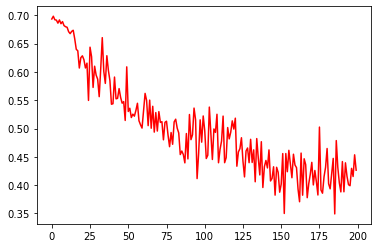

In [69]:
plt.plot(list(range(len(loss_vals))),loss_vals,'r')

In [70]:
loss_vals

[array(0.69333375, dtype=float32),
 array(0.6981912, dtype=float32),
 array(0.6919437, dtype=float32),
 array(0.69139814, dtype=float32),
 array(0.68602306, dtype=float32),
 array(0.6916546, dtype=float32),
 array(0.6849683, dtype=float32),
 array(0.68877584, dtype=float32),
 array(0.6816654, dtype=float32),
 array(0.67968893, dtype=float32),
 array(0.6787672, dtype=float32),
 array(0.6709569, dtype=float32),
 array(0.6675121, dtype=float32),
 array(0.6714632, dtype=float32),
 array(0.67344844, dtype=float32),
 array(0.6582306, dtype=float32),
 array(0.63979226, dtype=float32),
 array(0.63717663, dtype=float32),
 array(0.6067821, dtype=float32),
 array(0.625135, dtype=float32),
 array(0.6283146, dtype=float32),
 array(0.6215701, dtype=float32),
 array(0.60686547, dtype=float32),
 array(0.61538786, dtype=float32),
 array(0.5495833, dtype=float32),
 array(0.64356816, dtype=float32),
 array(0.6267832, dtype=float32),
 array(0.5725222, dtype=float32),
 array(0.60996026, dtype=float32),
 ar